**CURSO**: Análisis Geoespacial, Departamento de Geociencias y Medio Ambiente, Universidad Nacional de Colombia - sede Medellín <br/>
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Classroom code**: [32cjlau] <br />
**Credits**: The content of this notebook is taken from several sources, mainly from [Scikit GStat](https://github.com/mmaelicke/scikit-gstat/blob/master/docs/data/sample_sr.csv), the courses and book open and freely published by [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool & - Sergio Rey - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu). Every effort has been made to trace copyright holders of the materials used in this book. The author apologies for any unintentional omissions and would be pleased to add an acknowledgment in future editions.

# Geostatistic

The type of spatial statistical analysis dealing with continuous field variables is named “geostatistics”. Geostatistics focus on the description of the spatial variation in a set of observed values and on their prediction at unsampled locations. The basic idea of geostatistics is to describe and estimate spatial correlations in a set of point data. While the main tool, the variogram, is quite easy to implement and use, a lot of assumptions are underlying it. The typical application is geostatistics is an interpolation. Therefore, although using point data, a basic concept is to understand these point data as a sample of a (spatially) continuous variable that can be described as a random field, or to be more precise, a Gaussian random field in many cases. The most fundamental assumption in geostatistics is that any two values xi and xi+h are more similar, the smaller h is, which is a separating distance on the random field. In other words: close observation points will show higher covariances than distant points. In case this most fundamental conceptual assumption does not hold for a specific variable, geostatistics will not be the correct tool to analyse and interpolate this variable.

Sometimes, all we have available is a set of points with measurements for the variable of interest that do not match the points we want the information for. In this situation, a solution we can rely on is “spatial interpolation”. For a continuous geographical field measured at a set of points, “spatial interpolation” methods provide us a way to guess at at the value a field would take at sites we do not measure.

There are many sophisticated methods with which this can be done. Kriging, common in the sub-field of spatial statistics called “geostatistics,” is one such practice based on the theory of Gaussian Process Regression. Another common approach, geographically-weighted regression, provides unique model estimates at every control point, as well as predictions for places where there is no data. Here, though, we’ll use a very basic k-nearest neighbor prediction algorithm from scikit-learn to demonstrate the process. This process will select the nearest 10 listings, then compute the prediction using a weighted average of these nearest observations. To keep predictions relatively consistent, we will build an interpolation only for listings that are entire homes/apartments with two bedrooms:

Techniques used with points that represent samples of a continuous field are interpolation methods. Here, our point data represents sampled observations of an entity that can be measured anywhere within our study area. There are many interpolation tools available, but these tools can usually be grouped into two categories: deterministic and interpolation methods

### Proximity interpolation
It was introduced by Alfred H. Thiessen more than a century ago. The goal is simple: Assign to all unsampled locations the value of the closest sampled location. This generates a tessellated surface whereby lines that split the midpoint between each sampled location are connected thus enclosing an area. Each area ends up enclosing a sample point whose value it inherits.

<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-proximity-1.png" width="1000"></center>

In [20]:
from sklearn.neighbors import KNeighborsRegressor
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
airbnbs = gpd.read_file("https://geographicdata.science/book/_downloads/dcd429d1761a2d0efdbc4532e141ba14/regression_db.geojson")

In [22]:
two_bed_homes = airbnbs[airbnbs['bedrooms']==2 & airbnbs['rt_Entire_home/apt']]

In [23]:
two_bed_home_locations = np.column_stack((two_bed_homes.geometry.x, two_bed_homes.geometry.y))

To plot the interpolated surface, we must also construct a grid of locations for which we will make predictions. This can be done using numpy.meshgrid, which constructs all the combinations of the input dimensions as a grid of outputs.

In [24]:
xmin, ymin, xmax, ymax = airbnbs.total_bounds
x, y = np.meshgrid(np.linspace(xmin, xmax), np.linspace(ymin,ymax))

Text(0.5, 1.0, 'Y values')

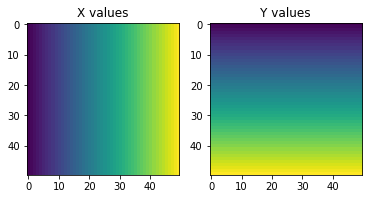

In [25]:
f,ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y)
ax[0].set_title('X values')
ax[1].set_title('Y values')

With these coordinates, we can make a geodataframe containing the grid cells at which we would like to predict:

In [26]:
grid = np.column_stack((x.flatten(), y.flatten()))
grid_df = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=x.flatten(), y=y.flatten()))

<AxesSubplot:>

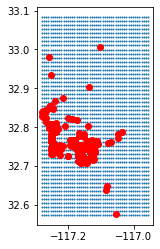

In [27]:
ax = grid_df.plot(markersize=1)
two_bed_homes.plot(ax=ax, color='red')

With this done, we can now construct the predictions. First we train the model:

In [31]:
model = KNeighborsRegressor(n_neighbors=5, weights='distance').fit(two_bed_home_locations, two_bed_homes.price)

In [32]:
predictions = model.predict(grid)

<AxesSubplot:>

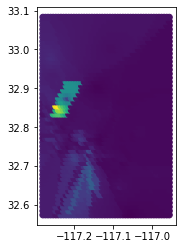

In [33]:
grid_df.plot(predictions)

### Inverse Distance Weighted (IDW)
The IDW technique computes an average value for unsampled locations using values from nearby weighted locations. The weights are proportional to the proximity of the sampled points to the unsampled location and can be specified by the IDW power coefficient.

$\hat{Z_j} = \frac{\sum_i{Z_i/d^n_{ij}}}{\sum_i{1/d^n_{ij}}}$

So a large $n$ results in nearby points wielding a much greater influence on the unsampled location than a point further away resulting in an interpolated output looking like a Thiessen interpolation. On the other hand, a very small value of n will give all points within the search radius equal weight such that all unsampled locations will represent nothing more than the mean values of all sampled points within the search radius.

<center><img src="http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture10/3Dconcepts/Inverse%20Distance%20Weighted_files/image001.gif" width="700"></center>

In [67]:
from scipy.spatial import Delaunay
tri = Delaunay(two_bed_home_locations)

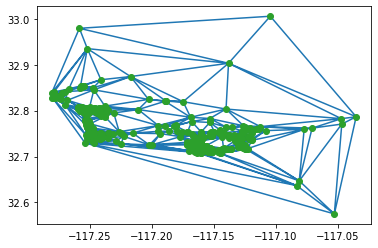

In [68]:
import matplotlib.pyplot as plt
plt.triplot(two_bed_home_locations[:,0], two_bed_home_locations[:,1], tri.simplices)
plt.plot(two_bed_home_locations[:,0], two_bed_home_locations[:,1], 'o')

In [85]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(two_bed_home_locations)

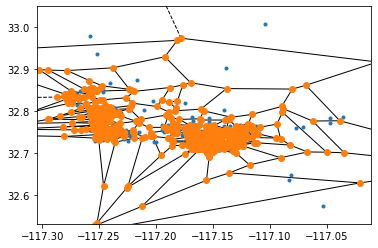

In [86]:
fig = voronoi_plot_2d(vor)
plt.show()

### Kriging
Several forms of kriging interpolators exist: ordinary, universal and simple just to name a few. This section will focus on ordinary kriging (OK) interpolation. This form of kriging usually involves four steps:

* Removing any spatial trend in the data
* Computing the experimental variogram, γ , which is a measure of spatial autocorrelation.
* Defining an experimental variogram model that best characterizes the spatial autocorrelation in the data.
* Interpolating the surface using the experimental variogram.
* Adding the kriged interpolated surface to the trend interpolated surface to produce the final output.

We are interested in how these attribute values vary as the distance 
							between location point pairs increases. We can compute the difference, $γ$, in values by squaring their 
							differences then dividing by 2.

<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f13-two-sites-1.png" width="1000"></center>
							$\gamma = \frac{(Z_2 - Z_1)^2}{2} = \frac{(-1.2 - (1.6))^2}{2} = 3.92$
                            

#### Experimental variogram                            
<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-variogram-1.png" width="800"></center>

<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-sample-variogram-1.png" width="800"></center>

#### Modelos de Variograma
<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-variogram-models-1.png" width="800"></center>

#### Parámetros
<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-model-explained-1.png" width="1000"></center>





 ## Scikit-Gstat
 [Scikit-gstat](https://scikit-gstat.readthedocs.io/en/latest/userguide/introduction.html) is a scipy-styled analysis module for geostatistics. It includes two base classes Variogram and OrdinaryKriging. Additionally, various variogram classes inheriting from Variogram are available for solving directional or space-time related tasks. The module makes use of a rich selection of semi-variance estimators and variogram model functions, while being extensible at the same time. 

In [3]:
!pip install scikit-gstat

     |████████████████████████████████| 79 kB 816 kB/s eta 0:00:01
  Created wheel for scikit-gstat: filename=scikit_gstat-0.4.3-py3-none-any.whl size=92155 sha256=448721beee4ce030c3d8b370944a47b7db76fa578108b02949ab8fd9b3327ae6
  Stored in directory: /home/jovyan/.cache/pip/wheels/21/1f/c2/c07aafdfdb71dc50444cce3293fe208e1dce5e716e29892c73
Successfully built scikit-gstat


In [48]:
import skgstat as skg
from skgstat import Variogram, OrdinaryKriging
import numpy as np
import pandas as pd

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/mmaelicke/scikit-gstat/master/docs/data/sample_sr.csv')
data.head(2)

,x,y,z
0,94,20,-0.394444
1,82,37,-2.283663


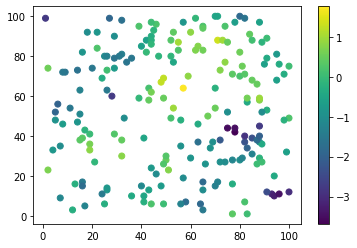

In [19]:
plt.scatter(data.x, data.y, c=data.z)
plt.colorbar()

We can already see a lot from here:

* The small values seem to concentrate on the upper left and lower right corner
* Larger values are arranged like a band from lower left to upper right corner

### Build a Variogram
The variogram relates pair-wise separating distances of `coordinates` and relates them to the *semi-variance* of the corresponding `values` pairs. The default estimator used is the Matheron estimator:

$$ \gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i + h}))^2 $$

For more details, please refer to the [User Guide](https://mmaelicke.github.io/scikit-gstat/userguide/variogram.html#experimental-variograms)

The Variogram class takes at least two arguments. The coordinates and the values observed at these locations. You should also at least set the normalize parameter to explicitly, as it changes it's default value in version 0.2.8 to False. This attribute affects only the plotting, not the variogram values. Additionally, the number of bins is set to 15, because we have fairly many observations and the default value of 10 is unnecessarily small. The maxlag set the maximum distance for the last bin. We know from the plot above, that more than 60 units is not really meaningful

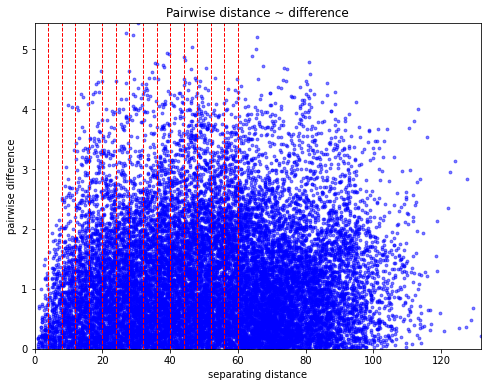

In [39]:
V.distance_difference_plot();

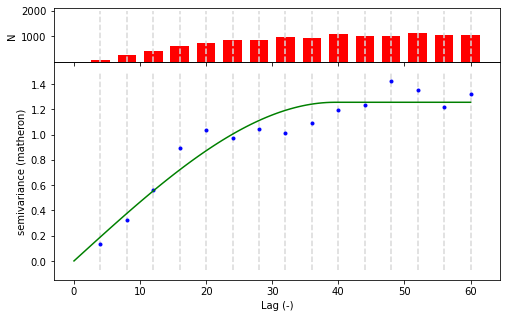

In [34]:
V = Variogram(data[['x', 'y']].values, data.z.values, normalize=False, maxlag=60, n_lags=15)
V.plot();

(array([ 553., 1349., 1801., 2072., 2301., 2352., 2351., 2271., 1969.,
        1479.,  901.,  352.,  126.,   16.,    7.]),
 array([  1.        ,   9.71968639,  18.43937278,  27.15905916,
         35.87874555,  44.59843194,  53.31811833,  62.03780472,
         70.7574911 ,  79.47717749,  88.19686388,  96.91655027,
        105.63623666, 114.35592304, 123.07560943, 131.79529582]),
 <BarContainer object of 15 artists>)

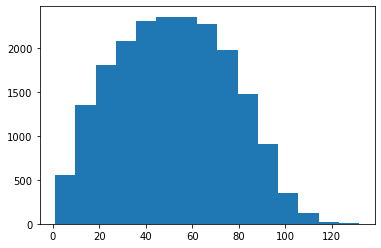

In [64]:
# apply binning
bin, _ = skg.binning.even_width_lags(V.distance, 15, None)

# get the histogram
plt.hist(V.distance,bins=15)

The upper subplot show the histogram for the count of point-pairs in each lag class. You can see various things here:

As expected, there is a clear spatial dependency, because semi-variance increases with distance (blue dots)
The default spherical variogram model is well fitted to the experimental data
The shape of the dependency is not captured quite well, but fair enough for this example

The sill of the variogram should correspond with the field variance. The field is unknown, but we can compare the sill to the sample variance:

In [43]:
print(data.z.var()) #sample variance
V.describe()['sill'] # Variogram sill

1.104387967773688


1.2553698540989082

The describe method will return the most important parameters as a dictionary. And we can simply print the variogram ob,ect to the screen, to see all parameters.

In [46]:
print(V.describe())

{'name': 'spherical', 'estimator': 'matheron', 'effective_range': 39.500272960385274, 'sill': 1.2553698540989082, 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': 60, 'n_lags': 15, 'verbose': False}, 'kwargs': {}}


### Kriging
The Kriging class will now use the Variogram from above to estimate the Kriging weights for each grid cell. This is done by solving a linear equation system. For an unobserved location $s_0$, we can use the distances to 5 observation points and build the system like:

$$
\begin{pmatrix}
\gamma(s_1, s_1) & \gamma(s_1, s_2) & \gamma(s_1, s_3) & \gamma(s_1, s_4) & \gamma(s_1, s_5) & 1\\
\gamma(s_2, s_1) & \gamma(s_2, s_2) & \gamma(s_2, s_3) & \gamma(s_2, s_4) & \gamma(s_2, s_5) & 1\\
\gamma(s_3, s_1) & \gamma(s_3, s_2) & \gamma(s_3, s_3) & \gamma(s_3, s_4) & \gamma(s_3, s_5) & 1\\
\gamma(s_4, s_1) & \gamma(s_4, s_2) & \gamma(s_4, s_3) & \gamma(s_4, s_4) & \gamma(s_4, s_5) & 1\\
\gamma(s_5, s_1) & \gamma(s_5, s_2) & \gamma(s_5, s_3) & \gamma(s_5, s_4) & \gamma(s_5, s_5) & 1\\
1 & 1 & 1 & 1 & 1 & 0 \\
\end{pmatrix} *
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\lambda_3 \\
\lambda_4 \\
\lambda_5 \\
\mu \\
\end{bmatrix} =
\begin{pmatrix}
\gamma(s_0, s_1) \\
\gamma(s_0, s_2) \\
\gamma(s_0, s_3) \\
\gamma(s_0, s_4) \\
\gamma(s_0, s_5) \\
1 \\
\end{pmatrix}
$$

Consequently, the `OrdinaryKriging` class needs a `Variogram` object as a mandatory attribute. Two very important optional attributes are `min_points` and `max_points`. They will limit the size of the Kriging equation system. As we have 200 observations, we can require at least 5 neighbors within the range. More than 15 will only unnecessarily slow down the computation. The `mode='exact'` attribute will advise the class to build and solve the system above for each location.

In [49]:
ok = OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

The transform method will apply the interpolation for passed arrays of coordinates. It requires each dimension as a single 1D array. We can easily build a meshgrid of 100x100 coordinates and pass them to the interpolator. To recieve a 2D result, we can simply reshape the result. The Kriging error will be available as the sigma attribute of the interpolator.

In [50]:
# build the target grid
xx, yy = np.mgrid[0:99:100j, 0:99:100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

And finally, we can plot the result.

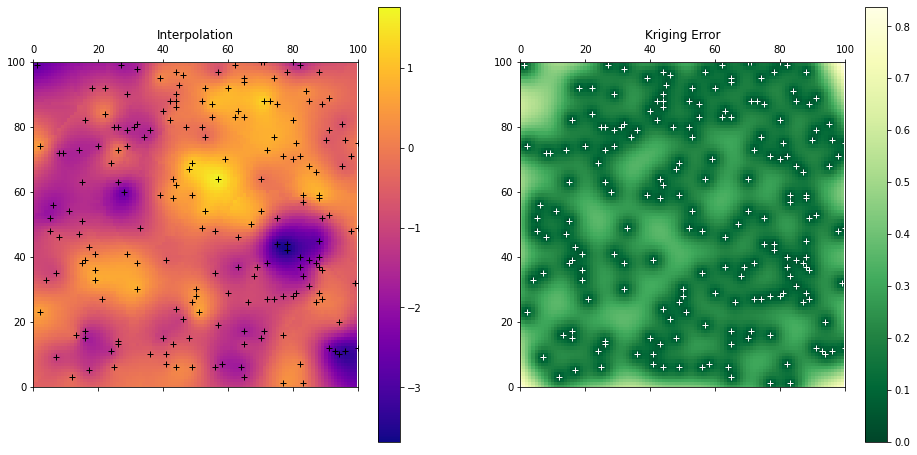

In [51]:

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

art = axes[0].matshow(field.T, origin='lower', cmap='plasma')
axes[0].set_title('Interpolation')
axes[0].plot(data.x, data.y, '+k')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(data.x, data.y, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));